In [1]:
import numpy as np
import torch as torch
import matplotlib.pyplot as plt


In [2]:
class NN(torch.nn.Module):
    def __init__(self, layers, activation_function=torch.tanh):
        super().__init__()
        self.Ws = torch.nn.ParameterList()
        self.bs = torch.nn.ParameterList()
        self.n_layers = len(layers)-1
        self.sigma = activation_function
        
        for i in range(self.n_layers):
            in_size = layers[i]
            out_size = layers[i+1]
            std_dev = np.sqrt(2/(in_size + out_size))
            W = torch.normal(
                0, std_dev,
                (out_size, in_size),
                requires_grad=True
            )
            b = torch.normal(
                0,
                std_dev,
                ( out_size, 1),
                requires_grad=True
            )
            
            self.Ws.append(W)
            self.bs.append(b)
    
    def forward(self, x):
        for i in range(self.n_layers-1):
            x = self.sigma(self.Ws[i] @ x + self.bs[i])
        
        return self.Ws[self.n_layers-1] @ x + self.bs[self.n_layers-1]

# First example: imitate a sine function

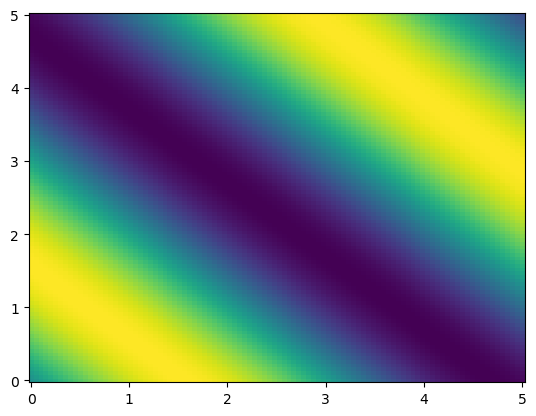

In [84]:
x_arr = np.linspace(0, 5, 100)
y_arr = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x_arr, y_arr)
Z = np.sin(X + Y)

fig = plt.figure()
ax = fig.subplots()
ax.pcolormesh(X, Y, Z)

x_train = np.stack(
    [X.reshape(-1), Y.reshape(-1)]
)
y_train = Z.reshape((1, -1))

x_train = torch.tensor(x_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)

tensor(1.1147, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(4.5684e-05, grad_fn=<MeanBackward0>)
tensor(3.0980e-05, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(1.4578e-05, grad_fn=<MeanBackward0>)
tensor(1.0750e-05, grad_fn=<MeanBackward0>)


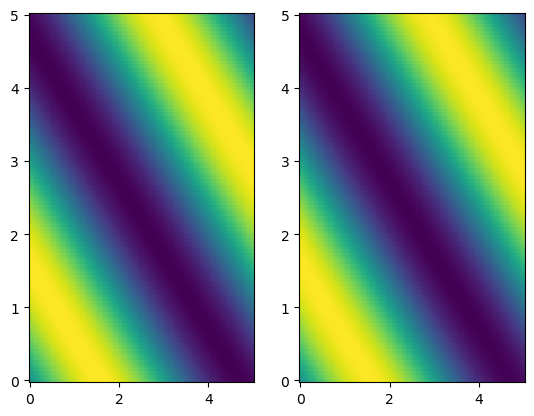

In [140]:
nn = NN([2, 10, 10, 10, 10, 1])

lr = 0.001
optimizer = torch.optim.Adam(nn.parameters(), lr=lr)
vanilla = False

for i in range(10000):
    loss = torch.mean(torch.square(nn.forward(x_train) - y_train))

    if i % 1000 == 0:
        print(loss)
    loss.backward()

    if vanilla:
        for parameter in nn.parameters():
            with torch.no_grad():
                parameter -= lr * parameter.grad
            parameter.grad.zero_()
    else:
        optimizer.step()
        optimizer.zero_grad()


with torch.no_grad():
    z_show = nn.forward(x_train)
    z_show = z_show.reshape(100, 100).numpy()
    
fig = plt.figure()
axes = fig.subplots(1, 2)
axes[0].pcolormesh(X, Y, Z)
axes[1].pcolormesh(X, Y, z_show)

# Getting Real

## IC and BC

In [3]:
T = 10
L = 1
n_ic = 100
n_bc = 100

t_start = 1
t_end = 3

x_ic = torch.stack([torch.linspace(0, L, n_ic), torch.zeros(n_ic)])
y_ic = torch.zeros((2, n_ic))


t_array = torch.linspace(0, T, n_bc)
pulse = torch.ones(n_bc)
zeros = torch.zeros(n_bc)
pulse[t_array < t_start] = 0
pulse[t_array > t_end] = 0

x_bc_l = torch.stack([torch.zeros(n_bc), t_array], 0)
y_bc_l = pulse.reshape(1, -1)

x_bc_r = torch.stack([torch.ones(n_bc), t_array], 0)
y_bc_r = torch.zeros((1, n_bc))

## Loss Functions

In [4]:
def get_data_loss(model: NN, x_train, y_train):
    y_nn = model(x_train)
    loss = torch.mean(torch.square(y_nn - y_train))
    return loss

def get_gradients(model: NN, x_train):
    y_derivative = torch.autograd.functional.jacobian(
        model, x_train
    )

    nice_solution = torch.zeros((2, 2, x_train.shape[1]))
    for i in range(x_train.shape[1]):
        nice_solution[:, :, i] += y_derivative[:, i, :, i]
    nice_solution = nice_solution.reshape(2, 2, -1)
    
    # y_nn = model(x_train)
    # gg = torch.autograd.grad(y_nn, x_train, grad_outputs=torch.ones_like(x_train))

    return nice_solution

def get_physics_loss(model: NN, x_train, coeff):
    y_nn = model(x_train)
    grads = get_gradients(model, x_train)
    v_x = grads[0, 0, :]
    v_t = grads[0, 1, :]
    i_x = grads[1, 0, :]
    i_t = grads[1, 1, :]
    
    eq_1 = v_x + coeff.L * i_t + coeff.R * y_nn[1,:]
    eq_2 = i_x + coeff.C * v_t + coeff.G * y_nn[0,:]
    
    full_error = torch.stack((eq_1, eq_2), 0)

    return torch.mean(torch.square(full_error))

class Coefficients:
    def __init__(self):
        R = 45.3*10**(-3)
        G = 0
        L = 0.205 * 10**(-6)
        C = 82*10**(-12)
        
        X = 100
        T = 10**(-6)
        V = 10

        self.L = 3.0
        self.C = 3.0
        self.R = 0.01
        self.G = 1/10**5

x_train = torch.tensor([[0., 1., 2.], [0., 1., 2.]])
# x_train = torch.tensor([[0.], [0.]])
x_train.requires_grad_(True)
model = NN([2, 5, 5, 5, 2])

output = get_physics_loss(model, x_train, Coefficients())

In [10]:
coeff = Coefficients()
model = NN([2, 5, 5, 5, 2])
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr)

ic_loss_hist = []
bc_loss_hist = []
phys_loss_hist = []

for epoch in range(10000):
    if epoch % 500 == 0:
        x_phys = np.random.uniform(0, L, 1000)
        t_phys = np.random.uniform(0, T, 1000)
        x_phys = np.stack([x_phys, t_phys], 0)
        x_phys = torch.tensor(x_phys, dtype=torch.float, requires_grad=True)

    optimizer.zero_grad()
    ic_loss = get_data_loss(model, x_ic, y_ic)
    bc_l_loss = torch.mean(torch.square(model(x_bc_l)[0,:] - y_bc_l))
    
    r_nn = model(x_bc_r)
    bc_r_loss = torch.mean(torch.square(r_nn[0, :] - 0.5 * r_nn[1,:]))
    

    phys_loss = get_physics_loss(model, x_phys, coeff)
    
    ic_loss_hist.append(ic_loss.detach().numpy())
    bc_loss_hist.append(bc_l_loss.detach().numpy() + bc_r_loss.detach().numpy())
    phys_loss_hist.append(phys_loss.detach().numpy())
    
    loss = ic_loss + bc_l_loss + bc_r_loss + 10*phys_loss
    loss.backward()
    if epoch % 1000 == 0:
        print(loss)

    optimizer.step()


tensor(2.6053, grad_fn=<AddBackward0>)
tensor(1.2121, grad_fn=<AddBackward0>)
tensor(1.8703, grad_fn=<AddBackward0>)
tensor(3.0220, grad_fn=<AddBackward0>)
tensor(4.8442, grad_fn=<AddBackward0>)
tensor(4.2165, grad_fn=<AddBackward0>)
tensor(6.7603, grad_fn=<AddBackward0>)
tensor(12.9637, grad_fn=<AddBackward0>)
tensor(127.3046, grad_fn=<AddBackward0>)
tensor(130.7160, grad_fn=<AddBackward0>)


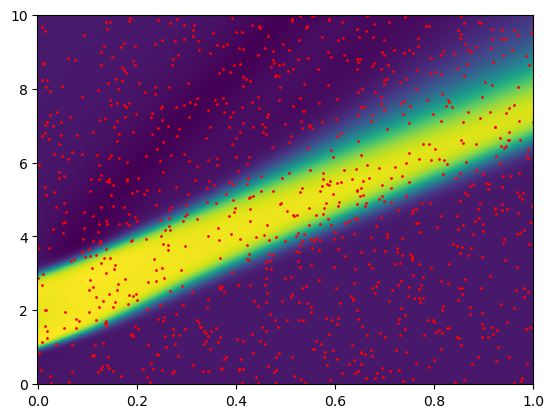

In [11]:
x_array = torch.linspace(0, L, 1000)
t_array = torch.linspace(0, T, 1000)

x_show = x_phys.detach().numpy()

X, Y = np.meshgrid(x_array, t_array)
input_test = np.stack(
    [X.reshape(-1), Y.reshape(-1)]
)

with torch.no_grad():
    output_test = model(input_test)
    v = output_test[0, :]
    V = v.reshape(1000, 1000)

fig = plt.figure()
ax = fig.subplots()
ax.pcolormesh(X, Y, V)
ax.scatter(x_show[0, :], x_show[1, :], c="r", s=1)


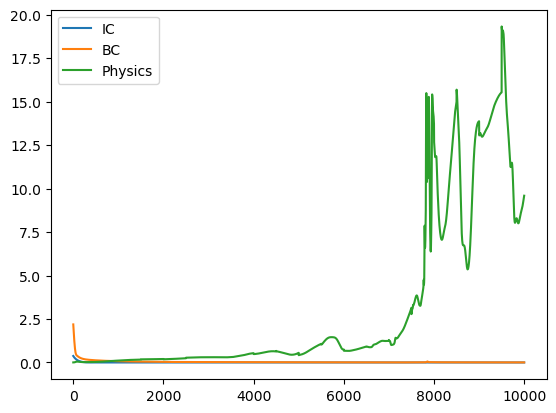

In [12]:
n = np.arange(len(phys_loss_hist))
fig = plt.figure()
ax = fig.subplots()

ax.plot(n, ic_loss_hist)
ax.plot(n, bc_loss_hist)
ax.plot(n, phys_loss_hist)
ax.legend(["IC", "BC", "Physics"])